In [1]:
import os
import logging
from datetime import datetime

In [2]:
import boto3
import sagemaker
import tarfile
import pickle
from sagemaker.session import TrainingInput
from sagemaker import image_uris
from sagemaker import hyperparameters

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


#### Settings

In [3]:
base_dir = '/home/sagemaker-user/sagemaker/01_Iris_simple_e2e' # The base dir on jupyer lab
bucket_name = 'sagemaker-bucket-ds' # Name of the bucket where data and model are stored
project_path_s3 = 'iris_v2' # path to the folder with the project
base_job_name = "iris-v2-xgboost-" # the prefix of the name of the training job. Datetime will be added as suffix to ensure uniqueness

#### Basic objects

In [4]:
sg_session = sagemaker.Session()
region = sg_session.boto_region_name
role_arn = sagemaker.get_execution_role()
s3 = boto3.client('s3')

print(region)
print(role_arn)

eu-west-1
arn:aws:iam::211125740051:role/service-role/AmazonSageMaker-ExecutionRole-20240607T130532


#### Create additional folders

In [5]:
s3.put_object(Bucket=bucket_name, Key=os.path.join(project_path_s3, 'model/'))
s3.put_object(Bucket=bucket_name, Key=os.path.join(project_path_s3, 'batch_inference_output/'))

{'ResponseMetadata': {'RequestId': 'JK3AFCEJG0TBJZ72',
  'HostId': '+eTvl2Z4cAkUf+prYECJng0Pia5GonJ9bz0gT7dwEbvurNKOiiZEpgPyqKnYYhnNY+1lyXiYmWbybsqBh/A0gw==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '+eTvl2Z4cAkUf+prYECJng0Pia5GonJ9bz0gT7dwEbvurNKOiiZEpgPyqKnYYhnNY+1lyXiYmWbybsqBh/A0gw==',
   'x-amz-request-id': 'JK3AFCEJG0TBJZ72',
   'date': 'Thu, 20 Jun 2024 12:51:30 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"d41d8cd98f00b204e9800998ecf8427e"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"d41d8cd98f00b204e9800998ecf8427e"',
 'ServerSideEncryption': 'AES256'}

#### Check the folder structure

In [6]:
!aws s3 ls {bucket_name}/{project_path_s3}/

                           PRE batch_inference_output/
                           PRE data/
                           PRE model/


In [ ]:
!aws s3 ls {bucket_name}/{project_path_s3}/data/ --recursive

#### Create train input files

In [ ]:
train_file = "data/iris_train.csv"
valid_file = "data/iris_test.csv"

train_file_uri = "s3://{}/{}/{}".format(bucket_name, project_path_s3, train_file)
valid_file_uri = "s3://{}/{}/{}".format(bucket_name, project_path_s3, valid_file)
print("train file uri:", train_file_uri)
print("valid file uri:", valid_file_uri)

train_ip = TrainingInput(train_file_uri, content_type="csv")
print(train_ip)

valid_ip = TrainingInput(valid_file_uri, content_type="csv")
print(valid_ip)

#### Get xgboost docker image

In [29]:
model_img = sagemaker.image_uris.retrieve("xgboost", region, "latest") # This function returns path to latest docker image
print(model_img)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest


#### Create estimator object

In [ ]:
model_op = "s3://{}/{}/{}".format(bucket_name, project_path_s3, "model") # The folder where the model will be stored
print(model_op)

In [ ]:
xgb_model = sagemaker.estimator.Estimator(
    image_uri=model_img, # Docker image that will be using on the instance
    role=role_arn, # role that will be used to execute
    base_job_name=base_job_name, # name of the job
    instance_count=1, # how many instances should be spawned
    instance_type="ml.m5.large", # size of the instance
    output_path=model_op, # where the output of the model should be saved
    sagemaker_session=sg_session,
    volume_size=5 # volume (in GB) assigned to the instance
)

#### Set hyperparameters

In [ ]:
xgb_model.set_hyperparameters(
    num_class=3, 
    max_depth=5,
    num_round=10,
    objective="multi:softmax",
)

#### Fit the model

In [ ]:
job_name = base_job_name + datetime.today().strftime("%Y-%m-%d-%H-%M-%S")
print(job_name)
xgb_model.fit({"train": train_ip, "validation": valid_ip}, wait=True, job_name=job_name)

If you go to sagemaker studio you can see the job in the jobs -> training
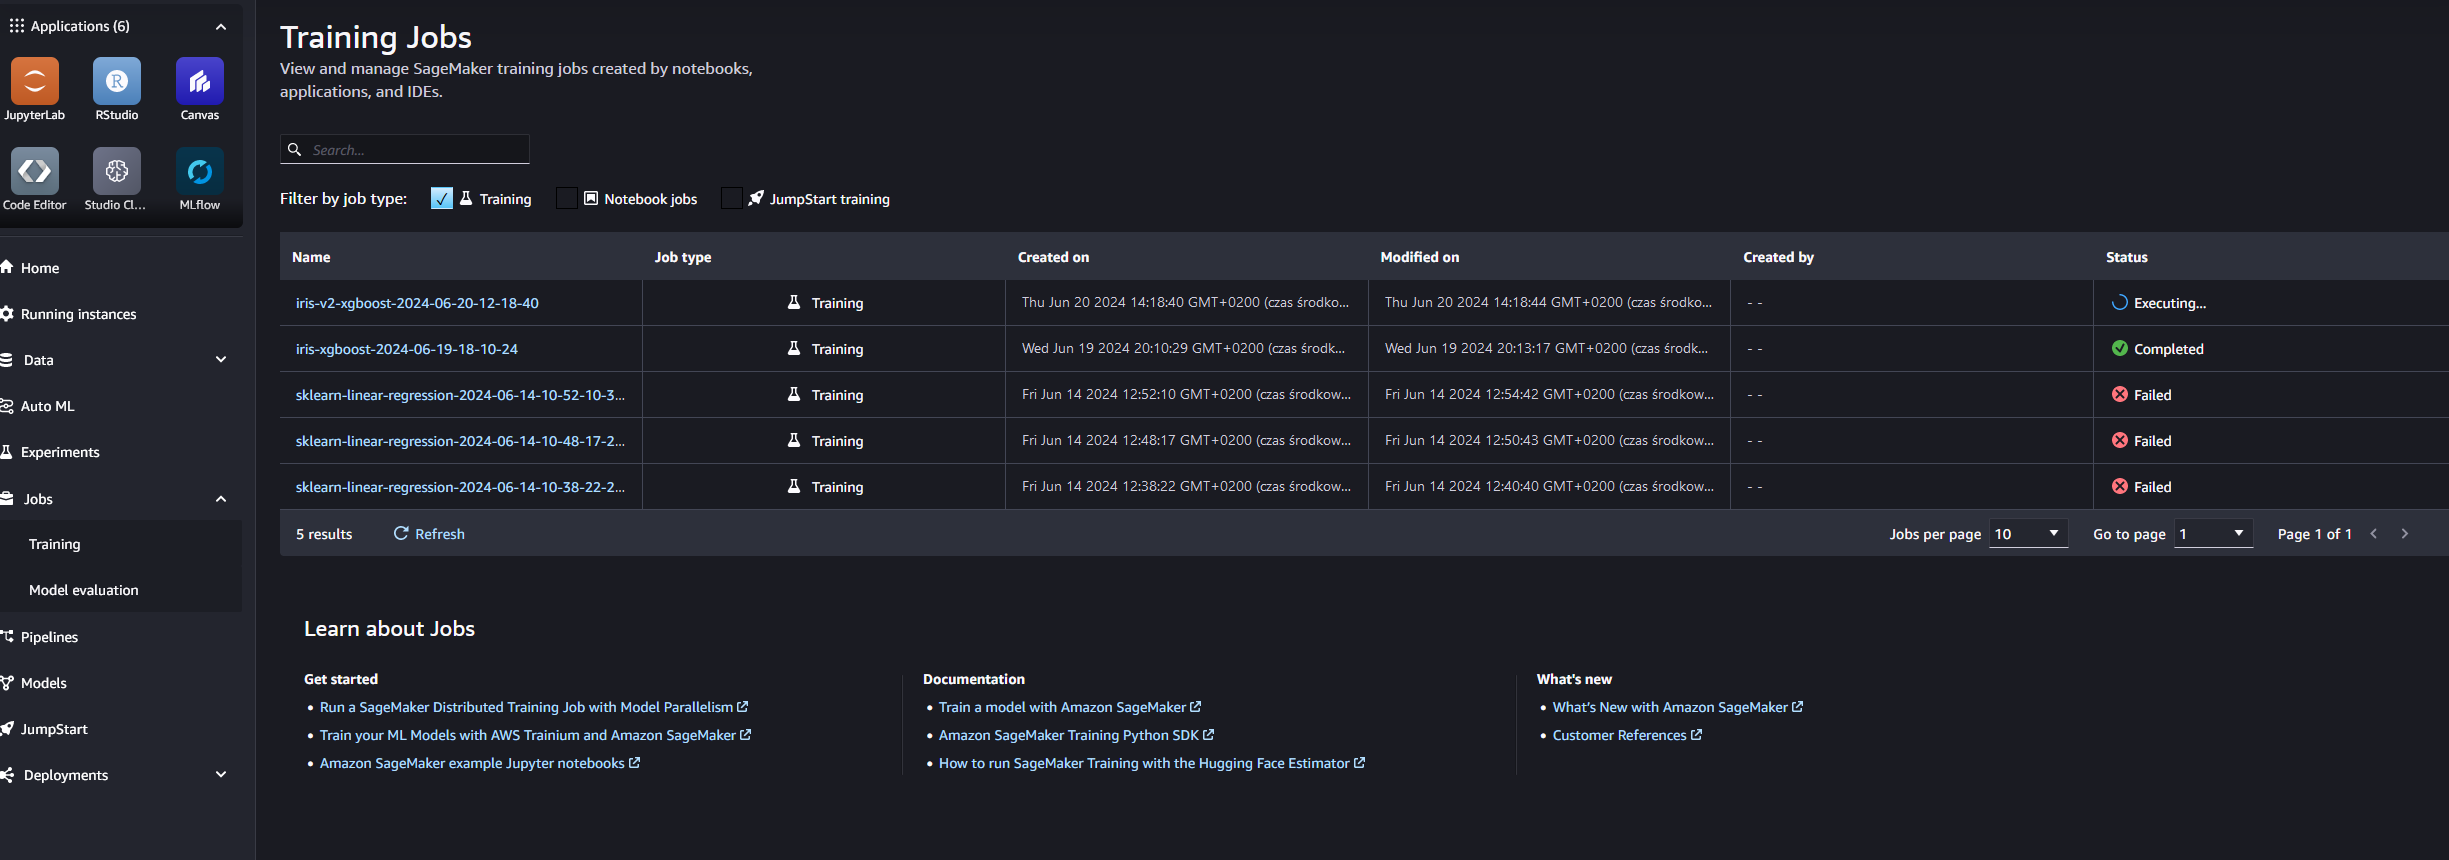

#### Lets check what is inside the output folder

In [22]:
!aws s3 ls {bucket_name}/{project_path_s3}/model/ --recursive

2024-06-20 12:51:30          0 iris_v2/model/
2024-06-20 12:53:53          0 iris_v2/model/iris-v2-xgboost-2024-06-20-12-51-32/debug-output/training_job_end.ts
2024-06-20 12:53:52       3453 iris_v2/model/iris-v2-xgboost-2024-06-20-12-51-32/output/model.tar.gz
2024-06-20 12:53:53          0 iris_v2/model/iris-v2-xgboost-2024-06-20-12-51-32/profiler-output/framework/training_job_end.ts
2024-06-20 12:53:49     131884 iris_v2/model/iris-v2-xgboost-2024-06-20-12-51-32/profiler-output/system/incremental/2024062012/1718887920.algo-1.json
2024-06-20 12:53:49     147015 iris_v2/model/iris-v2-xgboost-2024-06-20-12-51-32/profiler-output/system/incremental/2024062012/1718887980.algo-1.json
2024-06-20 12:53:53          0 iris_v2/model/iris-v2-xgboost-2024-06-20-12-51-32/profiler-output/system/training_job_end.ts


#### lets check what is inside the model object

Download model.tar.gz

In [23]:
model_dir = os.path.join(base_dir, 'model')
os.makedirs(model_dir, exist_ok=True) # Create data folder
model_path_s3 = os.path.join(project_path_s3, 'model', job_name, 'output', 'model.tar.gz')
model_path_local = os.path.join(model_dir, 'model.tar.gz')
s3.download_file(bucket_name, model_path_s3, model_path_local)

Check all files that are inside

In [24]:
with tarfile.open(model_path_local, 'r:gz') as tar:
    tar_list = tar.getnames()
    for name in tar_list:
        print(name)

xgboost-model


Extract the files

In [25]:
with tarfile.open(model_path_local, 'r:gz') as tar:
    tar.extractall(path=model_dir)
    print(f"Extracted all files to {model_dir}")

Extracted all files to /home/sagemaker-user/sagemaker/01_Iris_simple_e2e/model


We need to downgrade xgboost to version 0.90 due to compatibility issues

In [26]:
# Uninstall the current version of XGBoost
!pip uninstall -y xgboost

# Install XGBoost version 0.90
!pip install xgboost==0.90

import xgboost  as xgb
print("XGBoost version:", xgb.__version__)

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Successfully uninstalled xgboost-0.90
  Using cached xgboost-0.90-py2.py3-none-manylinux1_x86_64.whl.metadata (3.8 kB)
Using cached xgboost-0.90-py2.py3-none-manylinux1_x86_64.whl (142.8 MB)
XGBoost version: 0.90


Load the file

In [27]:
xgboost_path = os.path.join(model_dir, 'xgboost-model')
with open(xgboost_path, 'rb') as f:
    model = pickle.load(f)

The file inside model.tar.gz is a xgboost booster, which was dumped using pickle

In [28]:
model.__class__

xgboost.core.Booster